### Intervals analysis with fixed observation time
Here we want to study how the choice of the off-time ($t_\mathrm{off}$) affects the quality of the calibration strategy, based on the evaluation of three observables (total standard deviation $\sigma_\mathrm{tot}$, on standard deviation $\sigma_\mathrm{on}$, and sky-time fraction $f_\mathrm{sky}$). During this phase of the analysis, the on-time ($t_\mathrm{on}$) of each calibration strategy under consideration is equal to 10 minutes. This is an arbitrary but plausible choice.

In [ ]:
using Stripeline    #to simulate the movement of the telescope
using Healpix    #to produce maps from the simulations
using Plots    #to produce graphs resulting from the analysis
using Statistics    #to evaluate the standard deviation easily
using LaTeXStrings    #to use the LaTex typography in the plots

Since the Julia language is optimized for the use of functions, we define a series of functions usefull in the main code of this program. The meaning of some of these, can be better understood by looking at the main cycle of the program written below.

In [ ]:
#This function fill a single period (one t_off and one t_on) 
#of the tod representing the operation of the calibrator.
function period_tod(zeros, counts, durations, n, sampling)
    m=0
    while m<durations[3]    
        #m is a minute of the period, i is the index governing the tod
        if m<durations[1]    
            #here we are in the unstable part of the period (t_stab)
            v=0.5
            c=1
        end
        if m>=durations[1] && m<durations[2]    
            #here we are in the stable part of the period (t_cal)
            v=1
            c=1
        end
        if m>=durations[2] && m<durations[3]    
            #here we are in the t_off part of the period
            v=0
            c=2
        end
        b=((n*durations[3])+m)*sampling
        for a=1:sampling    
            #A complete cycle corresponds to an entire minute of the period, 
            #which corresponds to a number=sampling of components of the tod.
            if (b+a)<=length(zeros)
                zeros[b+a]=v
                counts[c]+=1
                a+=1
            end
            if (b+a)>length(zeros)
                a=sampling+10
                m=durations[3]+10
            end
        end
        m+=1
    end
end

#This function fill the entire tod using period_tod several times.
function fill_tod(zeros, counts, durations, periods, sampling, y) 
    #For each moment in wich the calibrator is on, the tod value should be 1 instead of 0, 
    #at the beginning of the experiment the calibrator is on. 
    #During the first minute of each ignition the tod value will be 0.5 
    #so that we can distinguish it from the following nine.
    for n=0:periods    
        #we fill each period separately using the previous function
        period_tod(zeros, counts, durations, n, sampling)
        n+=1
    end
end

#This function produce a map based on the simulation of the movements of the telescope
#considering also the functioning of the calibrator (represented by the tod).
function project_to_map(time_samples, map, tod)
    telescope_motors(time_s)=(0.0, deg2rad(20.0), timetorotang(time_s, 1))
    dirs, _=genpointings(telescope_motors, Float64[0, 0, 1], time_samples)   
    #we only need the direction so we omit the second return value
    for k in 1:length(time_samples)
        colat, long=dirs[k, :]    
        #we extract the colatitude and the longitude from dirs
        pixel_index=ang2pix(map, colat, long)
        if tod[k]>0    
            #We are studying the situation from the observations point of view,
            #so we are considering t_on without making a distinction between t_cal and t_stab.
            map[pixel_index]+=1    
            #Every time a pixel is covered by the calibrating signal (stable or not) 
            #its colour value (hit count) is increased by a constant value. 
            #This way we can see both wich parts of the sky are covered and 
            #how many times the calibrator obscures them.  
        end
        if tod[k]==0 && map[pixel_index]==0
            map[pixel_index]=0.5   
            #this way we can distinguish the pixels in the strip visible to the telescope 
            #from the ones out of it
        end
        if map[pixel_index]>0.5 && (map[pixel_index]%1)!=0
            map[pixel_index]-=0.5   
            #We want the pixel_index to represent the number of passages of the calibrator
            #over a pixel, so we do not want our method to identify the strip to ruin 
            #the physical meaning of the hit count.
        end
    end
end

#This function analyzes the pixels forming one of the maps produced using the simulations.
function pixels_counter(map)
    strip_pixels=0    
    #indicates the total number of pixels in the strip, we need this to evaluate the tot_dev_st
    on_pixels=0    
    #here we count only the pixels seen at least once when the calibrator is on,
    #usefull for the on_dev_st
    for u in 1:length(map.pixels)
        if map[u]!=0    
            #Because of the way we defined map[pixel_index] before, 
            #if this equals 0 the telescope never saw this pixel,
            #if the value is 0.5 the telescope saw the pixel but the calibrating signal never coverd it, 
            #if it equals 1 or more the calibrator covered it at least once. 
            #This way, only the pixels for which this value is not null are in the strip.
            strip_pixels+=1
        end
        if map[u]>=1    
            #we do not count the pixels always seen when the calibrator is off
            on_pixels+=1
        end
        u+=1
    end
    return strip_pixels, on_pixels
end

#This function fills the arrays keeping track of the hit count of the pixels under consideration.
function coveradge_counter(map, pixels, hit_count, tot_count_diff, on_count_diff, ideals) 
    j=1    
    #we need an index to controll the array that we are filling
    for r in 1:length(pixels)
        if map[r]==0.5    
            #this pixel was not covered by the calibrating signal so 
            #we put it in the strip pixels array but with its actual hit count null
            hit_count[j]=0
            tot_count_diff[j]=-ideals[1]
            #count_diff arrays are usefull in the standard deviation evaluation
            #ideals values are defined below
            j+=1    
            #we increment this index only when the hit count is >0
        end
        if map[r]>=1
            hit_count[j]=map[r]
            tot_count_diff[j]=hit_count[j]-ideals[1]
            on_count_diff[j]=hit_count[j]-ideals[2]
            j+=1
        end
        r+=1
    end
end

Here we define a series of usefull variables that will be used in the main part of the code.

In [ ]:
obs_time=60*24    #total observation time expressed in minutes
stab_duration=1    #stabilization time (t_stab) expressed in minutes
cal_duration=9    #stable ignition time (t_cal) expressed in minutes
frequency=50    #sampling frequency in Hz (i.e., number of samples per seconds)
sampling=frequency*60    #samples per minute (i.e., sampling frequency * 60 seconds)
time_samples=0.0:1/frequency:obs_time*60        
#array of time values in which we take measurements
#i.e., time range in seconds sampled using the chosen frequency
cal_intervals=50:1:190    
#We define an array of values that we will use as time between to ignitions to compare them, 
#here we express them in minutes.
#We define the associated arrays of standard deviations in the two different conditions 
#and the array of sky-time fractions.
dev_sts_tot=zeros(Float64, length(cal_intervals), 1)    
#the associated mean value will be defined using the number of pixels of the entire strip
dev_sts_on=zeros(Float64, length(cal_intervals), 1)    
#the associated mean value will be defined using only the pixels seen during the on-time
frac_time=zeros(Float64, length(cal_intervals), 1)
println(length(cal_intervals), "   |   ", length(time_samples))

Now we run a $\it{for}$ cycle in which, for each calibration strategy, we simulate the movement of the telescope and the action of the calibrator, then we evaluate the three observables of our analysis. 

In [ ]:
for ind in 1:length(cal_intervals)    #we run the cycle for each calibration strategy previously defined
    counts=[0, 0]   #Once filled, this array will be defined as follows:
    #first component = number of samples during which the calibrator is on, unstable or not; 
    #second component = number of samples during which the calibrator is off.
    durations=[stab_duration, cal_duration+stab_duration, cal_intervals[ind]+cal_duration+stab_duration]    
    #This array represents the division of a period of the calibrator action expressed in minutes. 
    #In particular, each one of its components is the time at which a phase of the period ends (t_stab, t_on, t_on+t_off).
    tod=zeros(Float64, length(time_samples), 1)    
    #the tod wich will be used to simulate the calibrator, initialized to zero as a start 
    n_per=cld(obs_time, durations[3])    
    #number of periods in which the total time can be divided rounded to the maximum integer possible  
    fill_tod(tod, counts, durations, n_per, sampling, 0)    #we fill the tod using the functions previously defined  
    map=Healpix.HealpixMap{Float64, RingOrder}(256)   #now we create a map wich represents the whole sky
    project_to_map(time_samples, map, tod)    #here we run the simulation
    #We evaluate in a quantitative way the uniformity of the calibrating signal coverage by studying map.pixels 
    #i.e., the array containing the count of the calibrator coverages of each pixel.
    #We need to select the part of the map that corresponds to the strip covered by Strip, 
    #this is the area in which we want the hit count to be uniform (tot_dev_st). 
    pixels=[0, 0]    
    #the first component will keep track of the number of pixels seen at least one by the calibrator on or off, 
    #the second will count only the pixels seen by the calibrator on (stable or not)
    pixels[1], pixels[2]=pixels_counter(map)
    ideals=[0., 0.]    #this will keep count of the ideal values
    ideals[1]=counts[1]/pixels[1]    #If all the pixels were seen the same number of times, 
    #this would be their hit count (i.e., their value in the map). This is the mean value for tot_dev_st.
    ideals[2]=counts[1]/pixels[2]    #mean value for on_dev_st
    #We define and fill three arrays to select only the data we need to make the actual analysis.
    hit_count=zeros(Float64, pixels[1], 1)    #hit count of every pixel in the strip
    tot_count_diff=zeros(Float64, pixels[1], 1)    
    #difference between the real count of every pixel in the strip and the ideal value
    on_count_diff=zeros(Float64, pixels[1], 1)    
    #difference between the real count of every pixel in the strip and the ideal value
    coveradge_counter(map, map.pixels, hit_count, tot_count_diff, on_count_diff, ideals)   
    #we fill the arrays using the function previuosly created 
    #we adjourn the final arrays
    dev_sts_tot[ind]=stdm(tot_count_diff, ideals[1], corrected=true)    
    #standard deviation considering the whole strip (tot_dev_st)
    dev_sts_on[ind]=stdm(on_count_diff, ideals[2], corrected=true)    
    #standard deviation considering only the on_pixels (on_dev_st)
    frac_time[ind]=counts[2]/length(time_samples)    #time during witch we see the sky (sky-time fraction)
    println("Component ", ind, " of ", length(cal_intervals), " has been processed.")    
    #since the whole cycle could take a wile to be completed, we print a message to take track of the progress
    ind+=1    #we increase the index controlling the main cycle
end

The main output of the thesis is a series of plots usefull to analyse the results. Here we produce these plots.

In [ ]:
#We plot the three dataset in a single cartesian plane and then separately, 
#this way we can have an overall view of the oucome of the analysis, as well as the possibility 
#to study some results more specifically.

plot(cal_intervals, dev_sts_tot, xlabel=L"t_\mathrm{off}\;[\mathrm{min}]", ylabel=L"\sigma", minorgrid=true, 
    markershape=:diamond, markersize=2, linewidth=0.8, linealpha=0.6, label=L"\sigma_\mathrm{tot}", legend=:top)
plot!(cal_intervals, dev_sts_on, markershape=:circle, markersize=2, markercolor=:green, 
    linewidth=0.8, linecolor=:green, linealpha=0.6, label=L"\sigma_\mathrm{on}")
plot!(twinx(), cal_intervals, frac_time, ylabel=L"f_\mathrm{sky}", markershape=:star5, markersize=2, 
    markercolor=:orange, linewidth=0.8, linealpha=0.6, linecolor=:orange, label=L"f_\mathrm{sky}", legend=:right)
savefig("plot_def_compl.pdf")

plot(cal_intervals, dev_sts_tot, xlabel=L"t_\mathrm{off}\;[\mathrm{min}]", ylabel=L"\sigma_\mathrm{tot}", minorgrid=true, 
    markershape=:circle, markersize=2, linewidth=0.8, linealpha=0.6, legend=:false)
savefig("plot_def_sdt.pdf")

plot(cal_intervals, dev_sts_on, xlabel=L"t_\mathrm{off}\;[\mathrm{min}]", ylabel=L"\sigma_\mathrm{on}", minorgrid=true, 
    markershape=:circle, markersize=2, markercolor=:green, linewidth=0.8, linecolor=:green, linealpha=0.6, legend=:false)
savefig("plot_def_sdo.pdf")

plot(cal_intervals, frac_time, xlabel=L"t_\mathrm{off}\;[\mathrm{min}]", ylabel=L"f_\mathrm{sky}", 
    minorgrid=true, markershape=:circle, markersize=2, markercolor=:orange, linewidth=0.8, 
    linecolor=:orange, linealpha=0.6, legend=:false)
savefig("plot_def_tf.pdf")

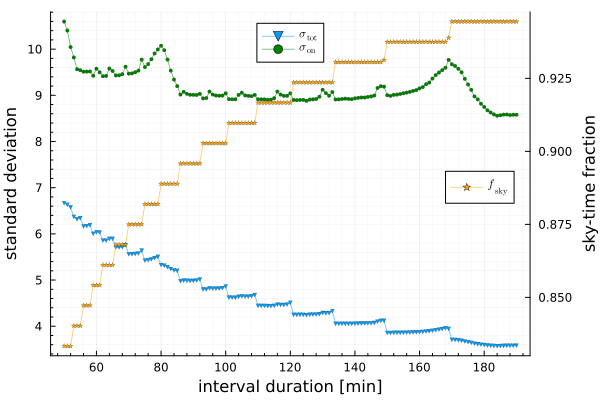

In [9]:
#To give the reader an overall idea of the results we plot here the three observables in a single plot.
plot(cal_intervals, dev_sts_tot, xlabel="interval duration [min]", ylabel="standard deviation", minorgrid=true, 
    markershape=:dtriangle, markersize=2, markerstrokewidth=0.2, linewidth=0.8, linealpha=0.6, 
    label=L"\sigma_\mathrm{tot}", legend=:top)
plot!(cal_intervals, dev_sts_on, markershape=:circle, markersize=2, markercolor=:green, 
    markerstrokewidth=0.2, linewidth=0.8, linealpha=0.6, linecolor=:green, label=L"\sigma_\mathrm{on}")
plot!(twinx(), cal_intervals, frac_time, ylabel="sky-time fraction", markershape=:star5, markersize=2.5, 
    markercolor=:orange, markerstrokewidth=0.2, linewidth=0.8, linecolor=:orange, linealpha=0.6, 
    label=L"f_\mathrm{sky}", legend=:right)